In [1]:
!pip install tensorflow-io
!pip install tensorflow-datasets

     |████████████████████████████████| 22.7MB 127kB/s 
     |████████████████████████████████| 2.3MB 37.6MB/s 


In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow import keras
import sklearn
import tensorflow_io as tfio
import tensorflow_datasets as tfds
from tensorflow.keras.utils import to_categorical

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:

test_images = tfio.IODataset.from_hdf5('/content/drive/MyDrive/images/test_pile_5000000.h5', dataset='/features')
test_targets_images = tfio.IODataset.from_hdf5('/content/drive/MyDrive/images/test_pile_5000000.h5', dataset='/targets', spec=tf.int64)

train_images = tfio.IODataset.from_hdf5('/content/drive/MyDrive/images/train_pile_10000000.h5', dataset='/features')
train_targets_images = tfio.IODataset.from_hdf5('/content/drive/MyDrive/images/train_pile_10000000.h5', dataset='/targets')




In [6]:
data_img = tf.data.Dataset.zip((train_images, train_targets_images)).prefetch(tf.data.experimental.AUTOTUNE).batch(1000000)
test_img = tf.data.Dataset.zip((test_images, test_targets_images)).prefetch(tf.data.experimental.AUTOTUNE).batch(500000)


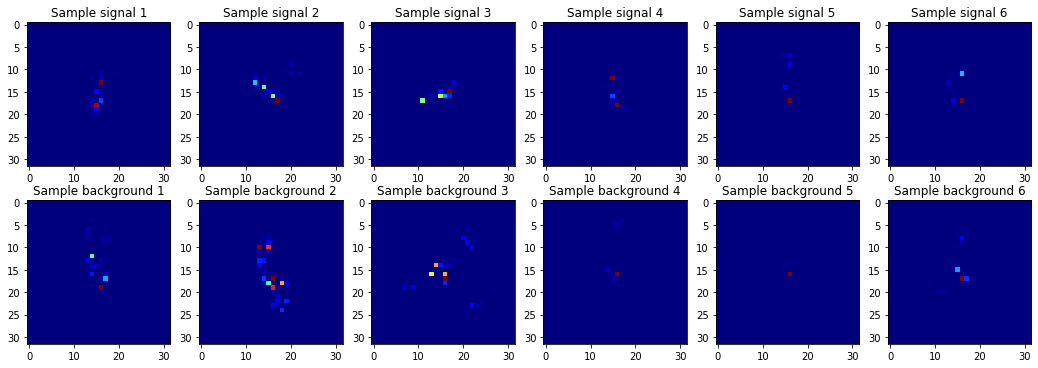

In [7]:
plt.figure(figsize=(18,6))
for feature, label in data_img.take(1):
  for i in range(6):
    plt.subplot(2,6,i+1)
    plt.imshow(feature[label>0.5][i+312], cmap='jet')
    plt.title('Sample signal %d' %(i+1))
    plt.subplot(2,6,i+7)
    plt.imshow(feature[label<0.5][i+312], cmap='jet')
    plt.title('Sample background %d' %(i+1))
plt.show()  

In [8]:


train_features = np.array([])
train_label = np.array([])

for feature, label in data_img.take(1).as_numpy_iterator():
  train_features = feature
  train_label = label

print(train_features.shape)
print(train_label.shape)  

(1000000, 1, 32, 32)
(1000000, 1)


In [9]:
test_features = np.array([])
test_label = np.array([])
for feature, label in test_img.take(1).as_numpy_iterator():
  test_features = feature
  test_label = label

In [10]:
def classifier_images_4():
  input = keras.Input(shape=(1, 32, 32), name='Input')
  x = keras.layers.Reshape((32, 32, 1))(input)
  
  x = keras.layers.LocallyConnected2D(30, kernel_size=(4, 4), strides = (4,4), activation='tanh')(x)
  
  x = keras.layers.LocallyConnected2D(30, kernel_size=(4, 4), strides = (4,4),  activation='tanh')(x)
  x = keras.layers.UpSampling2D(size=(2,2))(x)
  x = keras.layers.LocallyConnected2D(30, kernel_size=(4, 4), strides = (4,4),  activation='tanh')(x)
  x = keras.layers.Dense(30, activation='tanh')(x)
  x = keras.layers.Dense(30, activation='tanh')(x)
  
  x = keras.layers.Dense(30, activation='tanh')(x)
  x = keras.layers.Dense(30, activation='tanh')(x)
  x = keras.layers.Dense(30, activation='tanh')(x)
  x = keras.layers.Flatten(name='Flatten')(x)
  output = keras.layers.Dense(2, activation='sigmoid', name='output')(x)
  classifier = keras.Model(input, output, name='classifier')
    
  return classifier  

classifier_images_4=classifier_images_4()
classifier_images_4.summary()

Model: "classifier"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (InputLayer)           [(None, 1, 32, 32)]       0         
_________________________________________________________________
reshape (Reshape)            (None, 32, 32, 1)         0         
_________________________________________________________________
locally_connected2d (Locally (None, 8, 8, 30)          32640     
_________________________________________________________________
locally_connected2d_1 (Local (None, 2, 2, 30)          57720     
_________________________________________________________________
up_sampling2d (UpSampling2D) (None, 4, 4, 30)          0         
_________________________________________________________________
locally_connected2d_2 (Local (None, 1, 1, 30)          14430     
_________________________________________________________________
dense (Dense)                (None, 1, 1, 30)          9

In [11]:
def lr_decay(epoch):
  return LR_ST*0.9**epoch

lr_scheduler = keras.callbacks.LearningRateScheduler(lr_decay)

EarlyStop = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=0,
    patience=3,
    verbose=0,
    mode="auto",
    baseline=None,
    restore_best_weights=False,
)
# Callback for printing the LR at the end of each epoch.
class PrintLR(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    print('\n Learning rate for epoch {} is {}'.format(epoch + 1,
                                                      classifier_images_4.optimizer.lr.numpy()))

model_checkpoint = keras.callbacks.ModelCheckpoint(
        filepath='cnn_best',
        monitor='val_sparce_categorical_accuracy',
        save_weights_only=True, 
        save_best_only=True,
        save_freq='epoch')

# create a list with all the callbacks
callbacks = [ lr_scheduler, model_checkpoint, PrintLR(), EarlyStop ] 


print(model_checkpoint)

In [14]:
LR_ST=1e-4
classifier_images_4.compile(optimizer = keras.optimizers.Adam(learning_rate=LR_ST, beta_1=0.9, beta_2=0.999, epsilon=1e-08),
          loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
          metrics = [tf.keras.metrics.SparseCategoricalAccuracy(name='sparce_categorical_accuracy')]
)
history = classifier_images_4.fit(train_features, train_label, validation_split = 0.2, epochs=50, batch_size = 100, shuffle=True, verbose=1, callbacks=callbacks)

Epoch 1/50
8000/8000 [==============================] - 112s 14ms/step - loss: 0.3225 - sparce_categorical_accuracy: 0.8691 - val_loss: 0.3299 - val_sparce_categorical_accuracy: 0.8654

 Learning rate for epoch 1 is 9.999999747378752e-05
Epoch 2/50
8000/8000 [==============================] - 108s 14ms/step - loss: 0.3208 - sparce_categorical_accuracy: 0.8697 - val_loss: 0.3281 - val_sparce_categorical_accuracy: 0.8659

 Learning rate for epoch 2 is 9.000000136438757e-05
Epoch 3/50
8000/8000 [==============================] - 110s 14ms/step - loss: 0.3190 - sparce_categorical_accuracy: 0.8706 - val_loss: 0.3304 - val_sparce_categorical_accuracy: 0.8647

 Learning rate for epoch 3 is 8.099999831756577e-05
Epoch 4/50
8000/8000 [==============================] - 111s 14ms/step - loss: 0.3175 - sparce_categorical_accuracy: 0.8715 - val_loss: 0.3300 - val_sparce_categorical_accuracy: 0.8650

 Learning rate for epoch 4 is 7.2900002123788e-05
Epoch 5/50
8000/8000 [============================

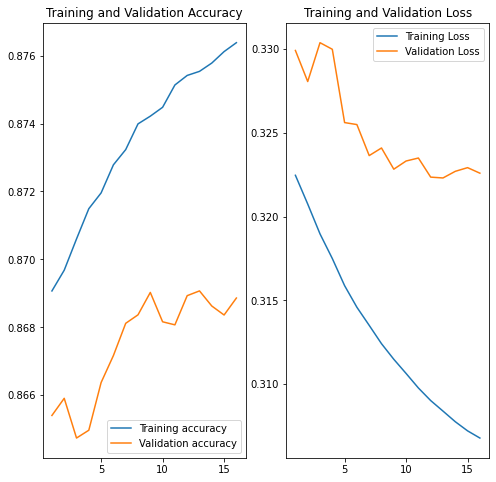

In [15]:
#plot of loss and metric during training

loss=history.history['loss']
val_loss=history.history['val_loss']

metric = history.history['sparce_categorical_accuracy']
val_metric = history.history['val_sparce_categorical_accuracy']

epochs_range = range(1, len(loss) + 1)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, metric, label='Training accuracy')
plt.plot(epochs_range, val_metric, label='Validation accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [16]:
test_loss, test_acc = classifier_images_4.evaluate(test_features,test_label)

15625/15625 [==============================] - 57s 4ms/step - loss: 0.3207 - sparce_categorical_accuracy: 0.8696


In [28]:
label_pred = classifier_images_4.predict(test_features)

In [18]:
print(label_pred)

[[0.51770014 0.3475142 ]
 [0.8704707  0.14319837]
 [0.6867675  0.23226017]
 ...
 [0.12944078 0.8619394 ]
 [0.8481048  0.21908113]
 [0.12272575 0.8634093 ]]


In [30]:
#label_pred = np.argmax(label_pred, axis = 1)
print(label_pred[:,1])

[0.3475142  0.14319837 0.23226017 ... 0.8619394  0.21908113 0.8634093 ]


In [23]:
test_label_onehot = to_categorical(test_label)

In [21]:

from sklearn import metrics


In [32]:
fpr, tpr, thresholds = metrics.roc_curve(test_label, label_pred[:,1])
AUC = metrics.auc(fpr, tpr)
print(AUC)

0.934720151464
